In [2]:
import matplotlib
import operator
import random
import scipy.stats as stats
import pandas as pd
import numpy
import copy
import json
import ast
from anytree import PreOrderIter
import math
import itertools
import scipy.stats as stats
import matplotlib.pyplot as pl
from operator import itemgetter, attrgetter, methodcaller
from scipy.stats import poisson
from docx import Document
from docx.text.run import Font, Run
from docx.dml.color import ColorFormat
from docx.shared import RGBColor
from time import time
from anytree import AnyNode
from anytree.exporter import JsonExporter



def timer_func(func):
    # This function shows the execution time of 
    # the function object passed
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func



'''
The multinomial CDF function is the implementation of Levin's "Representaion of Multinomial Cumulative Distribution Function"

G:= Number of total groups (including non-protected)
k:= Position
p:= Array of probabilities of each group to be selected
tau_p:= Array of number of protected items

EXAMPLE:
Groups: ["White"(NP), "Black"(P), "Asian"(P), "Hispanic"(P)]
k: 30
p: [0.4, 0.3, 0.2, 0.1]
tau_p: [k, 10, 5, 3]
The ranking is fair if multinomCDF(4, 30, p, tau_p) > a = 0.1 
'''

def multinomCDF_log(G, k, p, tau_p):
    s = float(k);
    log_cdf = -poisson.logpmf(k,s);
    gamma1 = 0.0;
    gamma2 = 0.0;
    sum_s2 = 0.0;
    sum_mu = 0.0;
    
    # P(W=k)
    for i in range(0,G):
        i = i-1
        sp = s*p[i];
        
        pcdf = poisson.cdf(tau_p[i],sp);
        log_cdf += numpy.log(pcdf);
        
        mu = sp*(1-poisson.pmf(tau_p[i],sp)/pcdf);
        s2 = mu-(tau_p[i]-mu)*(sp-mu);
        
        mr = tau_p[i];
        mf2 = sp*mu-mr*(sp-mu);
        
        mr *= tau_p[i]-1;
        mf3 = sp*mf2-mr*(sp-mu);
        
        mr *= tau_p[i]-2;
        mf4 = sp*mf3-mr*(sp-mu);
        
        mu2 = mf2+mu*(1-mu);
        mu3 = mf3+mf2*(3-3*mu)+mu*(1+mu*(-3+2*mu));
        mu4 = mf4+mf3*(6-4*mu)+mf2*(7+mu*(-12+6*mu))+mu*(1+mu*(-4+mu*(6-3*mu)));
        
        gamma1 += mu3;
        gamma2 += mu4-3*s2*s2;
        sum_mu += mu;
        sum_s2 += s2; 
    sp = numpy.sqrt(sum_s2);
    gamma1 /= sum_s2*sp;
    gamma2 /= sum_s2*sum_s2;
    
    x = (k-sum_mu)/sp;
    x2 = x*x;
    
    PWN = (-x2/2
    +numpy.log(1+gamma1/6*x*(x2-3)+gamma2/24*(x2*x2-6*x2+3)
    +gamma1*gamma1/72*(((x2-15)*x2+45)*x2-15))
    -numpy.log(2*math.pi)/2 -numpy.log(sp));
    
    log_cdf += PWN;
    return log_cdf;

def multinomCDF(G, k, p, tau_p):
    return numpy.exp(multinomCDF_log(G, k, p, tau_p ));

"""
To find a continuous multinomial icdf solution from a solution space.
Used for the Ranking Algorithm.
If the multinomial_CDF with tau alreay results in the value > a, return tau.
Else calculate the multinomial_CDF of tau in each case when each element of tau is increased by 1.
Compare the value and take the tau that produces the closest multinomial_CDF to a, which is also > a.

For example, initial tau: [0, 0, 0, 0]
if: 
    multinomial_CDF(G, k, p, tau) > a, return tau
else:
    compare:
        multinomial_CDF(G, k, p, [1, 0, 0, 0])
        multinomial_CDF(G, k, p, [0, 1, 0, 0])
        multinomial_CDF(G, k, p, [0, 0, 1, 0])
        multinomial_CDF(G, k, p, [0, 0, 0, 1])
    and take the increased tau with its multinomial_CDF > a and closest to a    

"""
def multinomial_icdf_continuous(G, k, p, a, tau):
    tau_p = [k] + list(tau);
    temp = copy.copy(tau_p)
    cdf = multinomCDF(G, k, p, tau_p)
    new_cdf = 0;
    initial = 1;
    not_fulfilled = 0;
    
    if(cdf > a):
        return tau_p;
    for i in range(len(tau_p)-1):
        temp[i+1] = temp[i+1]+1;
        if(initial == 1):
            tau_p = copy.copy(temp);
            cdf = multinomCDF(G, k, p, tau_p);
            initial = 0;
        else:
            new_cdf = multinomCDF(G, k, p, temp)
            if(new_cdf >= a and new_cdf >= cdf):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p); 
        if(new_cdf >= a or cdf >= a):
            temp[i+1] = temp[i+1]-1    
    return tau_p

"""
Finds the target group which does not achieve the minimum target.
"""
def find_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] > count[i+1]):
                return categories[i+1];  

def find_achieved_target(minimum_targets, count, categories):
    for i in range(len(minimum_targets)):
        if(minimum_targets[i] < count[i+1]):
                return categories[i+1];             

def get_num_categories(attributeNamesAndCategories):
    num_categories = 1
    for i in attributeNamesAndCategories.items():
        num_categories *= i[1]
    return num_categories    
    
def determineGroups(attributeNamesAndCategories):
    elementSets = []
    groups = []
    for attr, cardinality in attributeNamesAndCategories.items():
        elementSets.append(list(range(0, cardinality)))

    groups = list(itertools.product(*elementSets))
    return groups
@timer_func
def get_minimum_targets(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);

    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
        minimum_targets.append(numpy.array(tau_p));
        tau = copy.copy(tau_p);
    df = pd.DataFrame(data=(numpy.array(minimum_targets)).astype(int))
    df.columns = p[1:]
    df.index = numpy.array(range(k))+1
    df.to_html("minimum_target_table.html")    
    return minimum_targets   


@timer_func
def get_minimum_targets2(categories, p, alpha, k):
    positions = numpy.array(list(range(k))) + 1;
    minimum_targets = [];
    tau = numpy.zeros(len(categories)-1);
    block_sizes = []
    count=0
    
    for i in positions:
        tau_p = multinomial_icdf_continuous(len(p), i, p , alpha, tau)[1:]
                
        if(all(tau_p[j]==tau[j] for j in range(len(tau)))):
            count = count + 1
        else:
            block_sizes.append(count)
            count =1
        minimum_targets.append(numpy.array(tau_p));
        print ("tau_p: ",tau_p, " cdf: ",multinomCDF(len(categories),i, p, [i]+tau_p))
        tau = copy.copy(tau_p);
        
    block_sizes.append(count)        
    return minimum_targets, block_sizes


def separate_groups(data_set, categories, attributeItems):
    num_categories = len(categories)
    separateByGroups = [[] for _ in range(num_categories)]
    
    for i in data_set:
        categorieList = []
        for j in attributeItems:
            categorieList.append(i[j[0]])
        separateByGroups[categories.index(tuple(categorieList))].append(i)
        categorieList = []
    return separateByGroups    

def plot(data_set,attributeNamesAndCategories, attributeQuality):
    colors = ['black', 'red', 'blue', 'green', 'yellow','slategray', 'darkseagreen', 'indigo']
    markers = ['-o','-<','-s','-+', '-d', '-h', '-p', '-8']
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
    best = data_set[0][attributeQuality]
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)
    separateQualityByGroups = []
    fig = pl.figure(figsize=(20, 10))
    pl.subplot(211)
    round_2f = []
    for k in data_set:
        k[attributeQuality] = float(k[attributeQuality])/best
    
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        fit = stats.norm.pdf(separateQualityByGroups[i], numpy.mean(separateQualityByGroups[i]), numpy.std(separateQualityByGroups[i]))  
        pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=categories[i], color=colors[i])
#         pl.plot(separateQualityByGroups[i],fit,markers[i], markersize=6, label=label[i], color=colors[i])
        pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
        round_2f.append([round(elem, 2) for elem in separateQualityByGroups[i]])
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Probability Density Function')

    pl.subplot(212)
    pl.hist(round_2f,30, histtype='bar', label=categories, color=colors[:len(categories)])    
#     pl.hist(round_2f,30, histtype='bar', label=label, color=colors[:len(categories)])    
    pl.xlabel(attributeQuality+' (Quality)')
    pl.ylabel('Frequency')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
    pl.show()
    out_png = '../Plots/histo_plot.png'
    pl.savefig(out_png, dpi=100)    
    
def plot_scatter(data_set,attributeNamesAndCategories, attributeQuality):
#     label=['Germany','Turkey','Greece','Italy','Spain','France']
   
    colors = ['black', 'red', 'blue', 'green', 'yellow', 'magenta','slategray', 'darkseagreen', 'indigo']
    markers = ['o','<','s','>', 'd', 'x', 'h', 'p', '8']
    categories = determineGroups(attributeNamesAndCategories)
    attributeItems = attributeNamesAndCategories.items()
    separateQualityByGroups = []
    positionByGroups =[]
    for i in range(len(data_set)):
        data_set[i]['k']=i+1
    output_ranking_separated = separate_groups(data_set,categories, attributeItems)       
    fig = pl.figure(figsize=(6, 6), dpi=100)
    for i in range(len(categories)):
        separateQualityByGroups.append([quality[attributeQuality] for quality in output_ranking_separated[i]])
        positionByGroups.append([k['k'] for k in output_ranking_separated[i]])
        area = numpy.pi*4
        pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=categories[i], marker=markers[i])
#         pl.scatter(positionByGroups[i], separateQualityByGroups[i], s=area, color=colors[i], alpha=0.5, label=label[i], marker=markers[i])    
    pl.xlabel('Position (k)')
    pl.ylabel(attributeQuality+' (Quality)')
    pl.legend(loc='center left', fontsize='x-large', bbox_to_anchor=(1, 0.5))
#     pl.ylim(0, 6.0)
    pl.show()              
    out_png = '../Plots/scatter.png'
    pl.savefig(out_png, dpi=100)   


"""
    - data_set: list of items in dictionary form, which specifies its group and quality
        ex) 
        [{'Gender': 0, 'Uni score': 0.5344585435},
         {'Gender': 2, 'Uni score': 1.0160173543},
         {'Gender': 0, 'Uni score': 0.4573686375},
         {'Gender': 1, 'Uni score': 0.6513702354}]
         
    - attributeNamesAndCategories: attributes that are being used to specify groups in the data_set and its number of categories
        ex)
        {"Gender": 4}
    
    - attributeQuality: the name of the attribute used for quality
        ex)
        "Uni score"
        
    - k: total length of the ranking
    
    - p: array of prbability, that each group could be selected into the ranking
        ex)
        [0.4,0.3,0.2,0.1]
            -> 0.4 for Gender: 0 (Non-protected)
            -> 0.3 for Gender: 1 (Protected)
            -> 0.2 for Gender: 2 (Protected)
            -> 0.1 for Gender: 3 (Protected)
            
    - alpha: Percentage of Type I error     

    - color_blind: specifies if this is color blind ranking or not. 
      True for generating color blind ranking. For applying fair ranking algorithm with different Protected Groups, False.
        
"""    


# multinomFair(data_set, {'Group':4}, 'Score',500, [0.4,0.3,0.2,0.1], float(0.1), False)
@timer_func
def multinomFair(data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind):
    categories = determineGroups(attributeNamesAndCategories)
    num_categories = len(categories)
    count = [0 for _ in range(num_categories)];
    ranking = []
    random_choice = ""
    chosen = 0
    num = 1
    swap = 0
    target = ()
    separateByGroups = [[] for _ in range(num_categories)]
    attributeItems = attributeNamesAndCategories.items()
    
    no_remaining_items = 0
        
    #array of the attribute names
    attributes = [i[0] for i in attributeItems]

    #saves the generated ranking in .txt file
    f = open('ranking.txt', 'w')
    
    # Separate the groups into each list
    separateByGroups = separate_groups(data_set, categories, attributeItems)
    
    # Sort the items in ascending order of their quality
    for i in range(num_categories):
        separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality]) 
    
    if(color_blind):
        minimum_targets = numpy.zeros((k,num_categories-1))
    else:
        minimum_targets = get_minimum_targets(categories, p, alpha, k)
    
    for i in minimum_targets:
        for j in range(len(i)):
            if(i[j] > count[j+1] and chosen == 0):
                if(len(separateByGroups[j+1]) == 0):
                    no_remaining_items = 1
                    break
                item = separateByGroups[j+1].pop()
                ranking.append(item)
                f.write(str(item)+"\n")
                count[j+1] += 1;
                chosen = 1;
#                 print item
                if(any(count[a+1]<i[a] for a in range(len(i)))):
                    swap = len(ranking)-1;
                    # for edge case
                    while(any(count[a+1]<i[a] for a in range(len(i)))):
                        target = find_target(i, count, categories);
                        if(count[0] == 0):
                            achieved_target = find_achieved_target(i, count, categories);
                            if (all(ranking[swap][attributes[i]] == achieved_target[i] for i in range(len(attributes)))):
                                print ("item to swap: ",ranking[swap])
                                separateByGroups[categories.index(achieved_target)].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[categories.index(achieved_target)] -= 1
                        else:    
                            print ("Target group: ",target)
                            if (all(ranking[swap][a] == 0 for a in attributes)):
                                separateByGroups[0].append(ranking[swap])
                                ranking = ranking[:swap] + ranking[swap+1 :]
                                ranking.append(separateByGroups[categories.index(target)].pop())
                                count[categories.index(target)] += 1
                                count[0] -= 1;
                        swap -= 1;    
        if(no_remaining_items == 1):
            break
        if(chosen == 0):
            heads = []
            first = 0
            duplicates=[]
            for x in separateByGroups:
                if (len(x) == 0):
                    heads.append(-100)                 
                else:
                    heads.append(x[len(x)-1][attributeQuality])  
            most_val = max(heads)
            # handle cases when more than one group with the best score exists
            for l in range(len(heads)):
                if (heads[l]==most_val):
                    duplicates.append(l)

            if(len(duplicates)>1):
                if(color_blind):
                    idx = numpy.random.choice(duplicates)
                else:
                    p_random = [p[r] for r in duplicates]
                    p_random = numpy.array(p_random)/sum(p_random)
                    idx = numpy.random.choice(duplicates, 1, p=p_random)[0]
            else:    
                idx= duplicates[0]
            item = separateByGroups[idx].pop()
#             print item
            f.write(str(item)+"\n")
            ranking.append(item);
            count[idx] += 1;
        print (num, ": ", count, "Minimum Target: ",minimum_targets[num-1]);
        f.write(str(num)+": "+str(count)+"Minimum Target: "+str(minimum_targets[num-1])+"\n")
        print ("CDF: ", multinomCDF(num_categories, num, p, [num]+count[1:]))
        f.write("CDF: "+str(multinomCDF(num_categories, num, p, [num]+count[1:]))+"\n")
        num = num+1;
        chosen = 0;
    f.close()    
    rest = []
    best = ranking[0][attributeQuality]
    for i in separateByGroups:
        for j in i:
            rest.append(float(j[attributeQuality])/float(best))
    plot(ranking,attributeNamesAndCategories, attributeQuality)        
    plot_scatter(ranking,attributeNamesAndCategories, attributeQuality)
   
    for q in range(len(ranking)):
        ranking[q]['k']=q+1
        ranking[q]['Utility'] = (1.0/numpy.log(1 + q+1))*ranking[q][attributeQuality]
    
    # generates a .docx file that shows the generated ranking, in which each group is shown with different color.
    # the colors are set for maximum 6 different groups. If there are more than 6 groups, the colors have to be configured for those groups.     
    if(num_categories <=6):
        document = Document()
        document.add_heading("Output Ranking", 0)

        for idx in range(len(ranking)):
            if (all(ranking[idx][attributes[i]] == categories[0][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x3f, 0x2c, 0x36)
                
            elif (all(ranking[idx][attributes[i]] == categories[1][i] for i in range(len(attributes)))):
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xcc, 0x00, 0x00)
                
            elif (all(ranking[idx][attributes[i]] == categories[2][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x66, 0xff)
                
            elif (all(ranking[idx][attributes[i]] == categories[3][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x00, 0x99, 0x33)
                 
            elif (all(ranking[idx][attributes[i]] == categories[4][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xFF, 0xCC, 0x33)
       
            elif (all(ranking[idx][attributes[i]] == categories[5][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0x99, 0x66, 0x00)
 
            elif (all(ranking[idx][attributes[i]] == categories[6][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)

            elif (all(ranking[idx][attributes[i]] == categories[7][i] for i in range(len(attributes)))):  
                run = document.add_paragraph().add_run(str(ranking[idx]))
                font = run.font
                font.color.rgb = RGBColor(0xff, 0x00, 0xff)

        document.save('output_ranking_different_color.docx')
        
    return ranking  

def parseDataset(data_set, attributeName, categories):
    json_data = open(data_set).read()
    data = numpy.array(json_data.split("\n"))
    data_set = []
    group_count = numpy.zeros(categories)
    
    f = open('properties.txt', 'w')
    
    for i in data:
        data_set.append(ast.literal_eval(i))
    
    for j in range(len(data_set)):
        data_set[j]['Index']=j+1
        for i in range(categories):
            if(data_set[j][attributeNames]==i):
                group_count[i] = group_count[i]+1
        
    for i in range(categories):
        f.write("Group "+str(i)+": "+str(group_count[i])+"\n")
        print ("Group ",i,": ",group_count[i])
    
    f.write("Size of data set: "+str(len(data_set))+"\n")
    print ("Size of data set: ", len(data_set))
    f.close()  

    return data_set     



def child_generator_4(G, k, p ,a, tau):
    tau_p = [k] + list(tau) ;
    temp = copy.copy(tau_p)
    old_cdf = multinomCDF(G, k, p, tau_p)
    new_cdf = 0;
    initial = 1;
    not_fulfilled = 0;
    diz = {}
    ls = []
    i = 0

    if old_cdf > a:    
        return  tau
    
    for i in range(len(tau_p)-1):
        temp[i+1] = temp[i+1]+1;
        if(initial == 1):
            tau_p = copy.copy(temp);
            cdf = multinomCDF(G, k, p, tau_p);
            initial = 0;
            if (cdf > a):

                ls.append(tau_p[1:])
        
        
            
#             print(f"primo if: {tau_p,temp, cdf}");

        else:
            new_cdf = multinomCDF(G, k, p, temp)
            if(new_cdf > a):
                tau_p = copy.copy(temp);
                cdf = multinomCDF(G, k, p, tau_p)
            
                ls.append(tau_p[1:])
#                   print(f"secondopr_if: {tau_p,temp,cdf,new_cdf}")
        
        
#                 ls.append(tau_p);
        
            
#             print(f"secondo if: {tau_p,temp,cdf,new_cdf}")
        if(new_cdf >= a or cdf >= a or cdf <= a or new_cdf< a):
            temp[i+1] = temp[i+1]-1
        
    
    return ls

def countElements(group, list_):
    if group == 0:
        lista =  copy.copy(list_)
        return lista
    
    elif group == 1:
        
        list_[0] = list_[0] + 1
        lista =  copy.copy(list_)
        return lista
        
        
    elif group == 2:
        list_[1] = list_[1] + 1
        lista =  copy.copy(list_)
        return lista
        
                
    elif group == 3:
        list_[2] = list_[2] + 1
        lista =  copy.copy(list_)
        return lista
        
    
    

# if __name__ == '__main__'
#     import argparse
#     parser = argparse.ArgumentParser(description="data_set, attributeNamesAndCategories, attributeQuality, k, p, alpha, color_blind")
#     parser.add_argument('--data_set', metavar='path', required=True,
#                        help='path to the data set JSON file')
#     parser.add_argument('--attributeNamesAndCategories', required=True,
#                        help='protected attribute name and size in dictionary')
#     parser.addargument('--attributeQuality', required=True)
#     parser.addargument('--k', required=True)
#     parser.addargument('--p', required=True)
#     parser.addargument('--alpha',required=True)
#     parser.addargument('--color_blind',required=True)
#     args = parser.parse_args()
    
#     data = parseDataset(args.data_set)
    
#     multinomFair(data_set=data, attributeNamesAndCategories=args.attributeNamesAndCategories,
#                  attributeQuality=args.attributeQuality, k=args.k, p=args.p, 
#                  alpha=args.alpha, color_blind=args.color_blind)

# Partiamo dalle funzioni al livello più basso

In [16]:
json_data = open('.\german_credit.json').read()
data = numpy.array(json_data.split("\n"))
data_set = []
## Clean the data
for i in data:
    data_set.append(ast.literal_eval(i))
attribute = {'Group':4}  

#initialization

p = [0.4,0.3,0.2,0.1]

## Definiamo un parametro di loss L per bilanciare tra fairness e utilità
L = 0.6

#Sort Values
data_sert = sorted(data_set, reverse=True,key = lambda user: (user['Score']))
data_set = data_sert

for diz, i in zip(data_set, range(len(data_set))):
    diz['k'] = i + 1 
    

cb_rank = pd.DataFrame(data_set)
cb_rank['DCG_PreR'] = cb_rank['Score']/(numpy.log(2 + cb_rank['k']))

In [17]:
attributeQuality = 'Score'
protected_item = [key for key,value in attribute.items()][0]
categories = determineGroups({'Group':4})
num_categories = len(categories)
parent = list(numpy.zeros(num_categories-1))
separateByGroups = [[] for _ in range(num_categories)]
attributeItems = attribute.items()
dataset =[]
separateByGroups = separate_groups(data_set, categories, attributeItems)
for i in range(num_categories):
    separateByGroups[i] = sorted(separateByGroups[i], key=lambda item: item[attributeQuality],reverse=True)




In [18]:
parent_ = [0,0,0] 
## Scrivere la funzione 


for k in range(1,51):
    print(parent)
    child = child_generator_4(num_categories, k, p, float(0.2), parent)
    child_ls = []
    if numpy.array_equal(child, parent)== True:
        
        
#         dataset.append(separateByGroups[0].pop(0))
        ls = []
        count = 0
        chosen = 1
        for i in separateByGroups:
            
            
            for j in i:
                
                separateByGroups[count][0]['new_k'] = k
                if count == 0:
                    
                    separateByGroups[count][0]['alpha_c'] = multinomCDF(num_categories, k, p,  [k] + parent)
                    separateByGroups[count][0]['minimum_targets'] = parent
                    separateByGroups[count][0]['Utility'] = ((separateByGroups[count][0]['Score'])/(numpy.log(2 + k)))*L + (1-L)* separateByGroups[count][0]['alpha_c']
                    
                else:
                    parent_[count-1] = parent_[count-1] + 1
                    parent__ = copy.copy(parent_)
                    
                    separateByGroups[count][0]['minimum_targets'] = parent
                    separateByGroups[count][0]['alpha_c'] = multinomCDF(num_categories, k, p,  [k] + separateByGroups[count][0]['minimum_targets'])
                    separateByGroups[count][0]['Utility'] = ((separateByGroups[count][0]['Score'])/(numpy.log(2 + k)))*L + (1-L)* separateByGroups[count][0]['alpha_c']
                    parent_[count-1] = parent_[count-1] - 1
                ls.append(j)
                count = count + 1
                break
            
        print('Lavato con perlana')
        parent_ = max(ls, key=lambda x: x['Score'])['minimum_targets']

        parent = child
        print("Target minimo: ", parent, "\n")
        print(parent_, '\n')
        dataset.append( separateByGroups[max(ls, key=lambda x: x['Score'])[protected_item]].pop(0))
        
    else:
        
        for i in range(len(child)):
            print(child)
            diz = {}
            diz['Index_Group'] = child[i]
            index = numpy.nonzero(list(map(operator.sub, child[i], parent)))[0][0]
            diz['Item'] = separateByGroups[index + 1][0]
            
            parent__[index] = parent__[index] + 1  
            parent_= copy.copy(parent__)
            diz['Item']['minimum_targets'] = parent
            
            
            diz['Item']['new_k']   = k
            diz['Item']['alpha_c'] = multinomCDF(num_categories, k, p,  [k] + child[i])
            diz['Item']['Utility'] = ((diz['Item']['Score'])/(numpy.log(2 + diz['Item']['new_k'])))*L + (1-L)* diz['Item']['alpha_c']
            child_ls.append( diz)
            
            parent__[index] = parent__[index] - 1 
            
        
        print('Lavato con mastrolindo')
        dataset.append( separateByGroups[max(child_ls, key=lambda x: x['Item']['Utility'])['Item'][protected_item]].pop(0))
        
        parent = max(child_ls, key=lambda x: x['Item']['Utility'])['Index_Group']
        
        print("Target minimo: ", parent, "\n")
        print(parent_, '\n')
        
        
        



[0.0, 0.0, 0.0]
Lavato con perlana
Target minimo:  [0.0, 0.0, 0.0] 

[0.0, 0.0, 0.0] 

[0.0, 0.0, 0.0]
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
Lavato con mastrolindo
Target minimo:  [1.0, 0.0, 0.0] 

[0, 0, 2] 

[1.0, 0.0, 0.0]
Lavato con perlana
Target minimo:  [1.0, 0.0, 0.0] 

[1.0, 0.0, 0.0] 

[1.0, 0.0, 0.0]
[[1.0, 1.0, 0.0]]
Lavato con mastrolindo
Target minimo:  [1.0, 1.0, 0.0] 

[0, 1, 3] 

[1.0, 1.0, 0.0]
[[2.0, 1.0, 0.0], [1.0, 2.0, 0.0], [1.0, 1.0, 1.0]]
[[2.0, 1.0, 0.0], [1.0, 2.0, 0.0], [1.0, 1.0, 1.0]]
[[2.0, 1.0, 0.0], [1.0, 2.0, 0.0], [1.0, 1.0, 1.0]]
Lavato con mastrolindo
Target minimo:  [2.0, 1.0, 0.0] 

[0, 0, 4] 

[2.0, 1.0, 0.0]
[[3.0, 1.0, 0.0], [2.0, 2.0, 0.0], [2.0, 1.0, 1.0]]
[[3.0, 1.0, 0.0], [2.0, 2.0, 0.0], [2.0, 1.0, 1.0]]
[[3.0, 1.0, 0.0], [2.0, 2.0, 0.0], [2.0, 1.0, 1.0]]
Lavato con mastrolindo
Target minimo:  [2.0, 1.0, 1.0] 

[0, 0, 4] 



In [19]:
new_rank = pd.DataFrame(dataset)
lista = [0,0,0]
new_rank['tau'] = new_rank['Group'].apply(lambda x: countElements(x,lista))
new_rank.apply(lambda x: x['tau'].insert(0,x['new_k']), axis=1)
new_rank['alpha_adj'] = new_rank['tau'].apply(lambda x: multinomCDF(num_categories, x[0], p,  x))
new_rank['Utility_adj'] = (new_rank['Score'])/(numpy.log(2 + new_rank['new_k']))*L + (1-L)* new_rank['alpha_adj']
# BelRank = pd.DataFrame(dataset)
new_rank['DCG'] = new_rank['Score']/(numpy.log(2 + new_rank['new_k']))
L_list = numpy.arange(0, 1.01, 0.01)
a_list = numpy.arange(0, 0.21, 0.01)

# Greedy wise utility

In [33]:
import Greedy_Wise_Utility
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t



intervals_utility = []
intervals_alpha = []
alpha = 0.1
attributeQuality = 'Score'
res = []
confidence = 0.90
for L in L_list:
    
    json_data = open('.\german_credit.json').read()
    data = numpy.array(json_data.split("\n"))
    data_set = []
    ## Clean the data
    for i in data:
        data_set.append(ast.literal_eval(i))    
    attribute = {'Group':4}  
    
    
    #initialization
#     alpha = 0.1
    p = [0.4,0.3,0.2,0.1]
    k_th = 51
    ## Definiamo un parametro di loss L per bilanciare tra fairness e utilità
    
    attributes = {'Group':4}
    #Sort Values
    data_sert = sorted(data_set, reverse=True,key = lambda user: (user['Score']))
    data_set = data_sert
    
    for diz, i in zip(data_set, range(len(data_set))):
        diz['k'] = i + 1 
    
    
    cb_rank = pd.DataFrame(data_set)
    cb_rank['DCG_PreR'] = cb_rank['Score']/(numpy.log(2 + cb_rank['k']))
    new_rank, exposureByGroups, countByGroups, exposureStd, alphaByGroups, DCGByGroups = Greedy_Wise_Utility.GWU(data_set, p, alpha, k_th, attributeQuality, attributes, 'Group', L)
       
    new_rank['PreR_DCG'] = new_rank['Score']/(numpy.log(2 + new_rank['k']))
    new_rank['PostR_DCG'] = new_rank['Score']/(numpy.log(2 + new_rank['new_k']))
    new_rank['Utility_Loss_individual'] = new_rank['PostR_DCG']-new_rank['PreR_DCG']
    new_rank['Utility_Loss_position'] = new_rank['PostR_DCG']-cb_rank['DCG_PreR']
    new_rank['ULP*ULI'] = new_rank['Utility_Loss_position']*new_rank['Utility_Loss_individual']
    
    # calculate the kendall's correlation between two variables
    # calculate kendall's correlation    
    coef, p = kendalltau(new_rank['PostR_DCG'], cb_rank['DCG_PreR'].head(50))
#     print('Kendall correlation coefficient: %.3f' % coef)
    # interpret the significance
#     alpha = 0.1
#     if p > alpha:
#         print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
#     else:
#         print('Samples are correlated (reject H0) p=%.3f' % p)
    
    diz_results = {}
    diz_exposure = {}    
    diz_results['L'] = L
    diz_results['Utility'] = new_rank['Utility_adj'].sum()
    diz_results['Utility_mean'] = new_rank['Utility_adj'].mean()
    diz_results['Utility_std'] = new_rank['Utility_adj'].std()
    
    
    diz_results['alpha_adj'] = new_rank['alpha_adj'].mean()
    diz_results['alphaAdjStd'] = new_rank['alpha_adj'].std()
    dof = len(new_rank)-1 
    
    
    t_crit = numpy.abs(t.ppf((1-confidence)/2,dof))
    
    
    diz_exposure['exposureByGroups'] = exposureByGroups
    diz_exposure['L'] = L
    diz_exposure['countByGroups'] = countByGroups
    diz_exposure['exposureStd'] = exposureStd
    diz_results['ExposureByGroups'] = diz_exposure
    
    
    interval_utility =(diz_results['Utility_mean']-diz_results['Utility_std']*t_crit/numpy.sqrt(dof+1)
                      ,diz_results['Utility_mean']+diz_results['Utility_std']*t_crit/numpy.sqrt(dof+1)) 
    
    
    
    interval_alpha = (diz_results['alpha_adj']-diz_results['alphaAdjStd']*t_crit/numpy.sqrt(dof+1)
                     ,diz_results['alpha_adj']+diz_results['alphaAdjStd']*t_crit/numpy.sqrt(dof+1)) 
    
    
    
#     new_rank.groupby
    diz_results['lower_alpha_int'] = interval_alpha[0]
    diz_results['upper_alpha_int'] = interval_alpha[1]
    
    intervals_alpha.append(interval_alpha)
    intervals_utility.append(interval_utility)
    diz_results['Kendal_tau'] = coef 
    
    
    res.append(diz_results)
    
df_res = pd.DataFrame(res)

Function 'GWU' executed in 0.6711s
Function 'GWU' executed in 0.5579s
Function 'GWU' executed in 0.5616s
Function 'GWU' executed in 0.6634s
Function 'GWU' executed in 0.7253s
Function 'GWU' executed in 0.6658s
Function 'GWU' executed in 0.5934s
Function 'GWU' executed in 0.6328s
Function 'GWU' executed in 0.7742s
Function 'GWU' executed in 0.7365s
Function 'GWU' executed in 0.7229s
Function 'GWU' executed in 0.6703s
Function 'GWU' executed in 0.6146s
Function 'GWU' executed in 0.5942s
Function 'GWU' executed in 0.6735s
Function 'GWU' executed in 0.6557s
Function 'GWU' executed in 0.5997s
Function 'GWU' executed in 0.6131s
Function 'GWU' executed in 0.6166s
Function 'GWU' executed in 0.6034s
Function 'GWU' executed in 0.5900s
Function 'GWU' executed in 0.5765s
Function 'GWU' executed in 0.5876s
Function 'GWU' executed in 0.6514s
Function 'GWU' executed in 0.5941s
Function 'GWU' executed in 0.5984s
Function 'GWU' executed in 0.5651s
Function 'GWU' executed in 0.6268s
Function 'GWU' execu

In [35]:
# df_res['alpha_t'] = a_list

In [37]:
exposureData = []
intervalsExposure = []
for row in df_res['ExposureByGroups']:
    count = 0
    for meanExp, countExp, exposureStd in zip(row['exposureByGroups'], row['countByGroups'], row['exposureStd']):
        diz = {}
        diz['Group'] = count
        diz['averageExposure'] = meanExp
        diz['lenGroup'] = countExp -1
        diz['exposureStd'] = exposureStd
        t_crit = numpy.abs(t.ppf((1-confidence)/2,dof))
        
        interval_utility = (diz['averageExposure'] - diz['exposureStd']*t_crit/numpy.sqrt(diz['lenGroup'])
        ,diz['averageExposure'] + diz['exposureStd'] * t_crit/numpy.sqrt(diz['lenGroup'])) 
        
        diz['upper_int']=interval_utility[1]
        diz['lower_int'] = interval_utility[0]
        
#         intervalsExposure.append(interval_utility)
        diz['L'] = row['L']
#         diz['alpha_t'] = alpha
        count = count + 1
        exposureData.append(diz)

exposureDf = pd.DataFrame(exposureData)

# Analisi di sensitività L

# Plot della media delle exposure per ogni gruppo con intervalli di confidenza al variare di L

In [39]:
# f = plt.figure(figsize=(10, 10))
# sns.scatterplot(x=(exposureDf['alpha_t']), y=exposureDf['averageExposure'], palette="tab10", hue=exposureDf['Group'])

<AxesSubplot:xlabel='L', ylabel='averageExposure'>

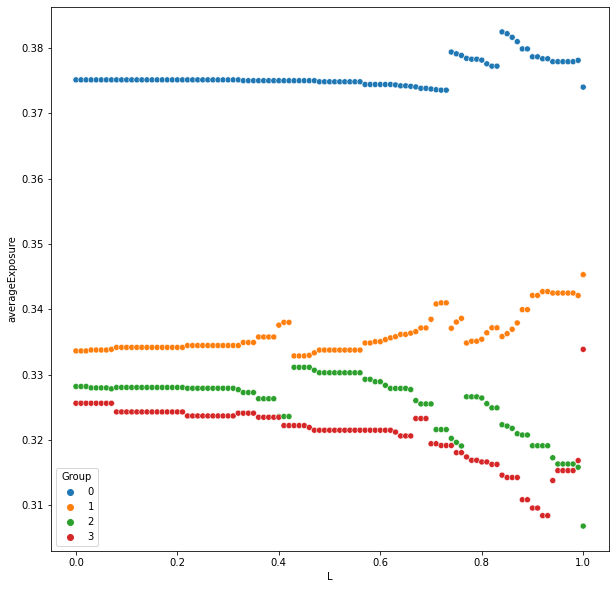

In [40]:
f = plt.figure(figsize=(10, 10))
sns.scatterplot(x=(exposureDf['L']), y=exposureDf['averageExposure'], palette="tab10", hue=exposureDf['Group'])

# Intervallo di confidenza per alpha aggiustato

Text(0, 0.5, 'alpha_c')

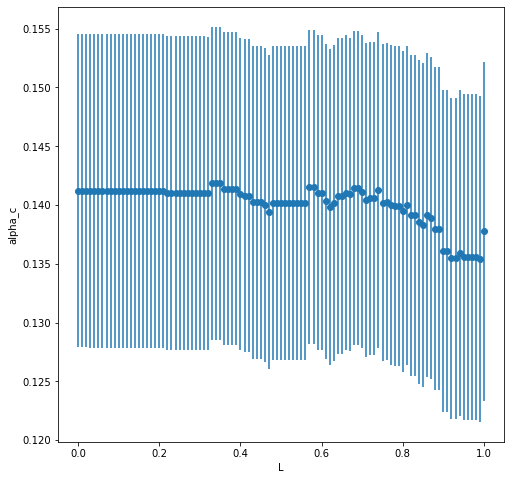

In [41]:

plt.figure(figsize=(8,8))

plt.errorbar(x=df_res['L'], 
             y=df_res['alpha_adj'], 
             yerr=[(top-bot)/2 for bot,top in intervals_alpha],
             fmt='o')

plt.xlabel('L')
plt.ylabel('alpha_c')



# Intervallo di confidenza per l'utilità aggiustata

<ErrorbarContainer object of 3 artists>

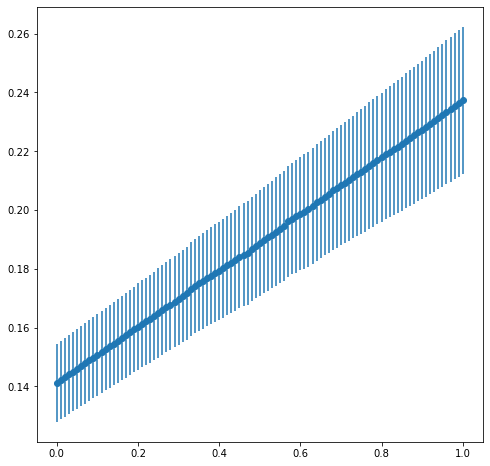

In [42]:

plt.figure(figsize=(8,8))

plt.errorbar(x=df_res['L'], 
             y=df_res['Utility_mean'], 
             yerr=[(top-bot)/2 for bot,top in intervals_utility],
             fmt='o')




# L vs alpha adjusted

<AxesSubplot:xlabel='L', ylabel='alpha_adj'>

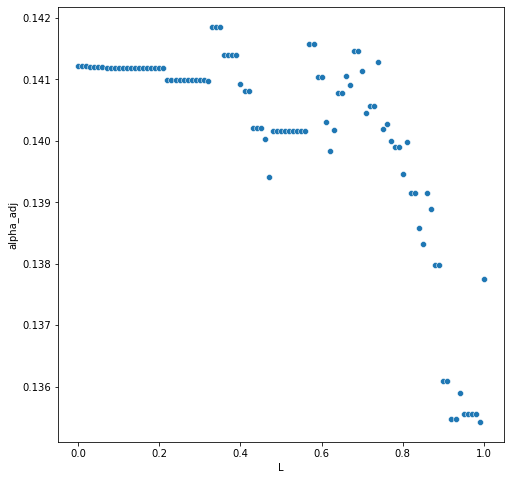

In [43]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(x=(df_res['L']), y=(df_res['alpha_adj']), palette="tab10")



# L vs Kenda_tau

<AxesSubplot:xlabel='L', ylabel='Kendal_tau'>

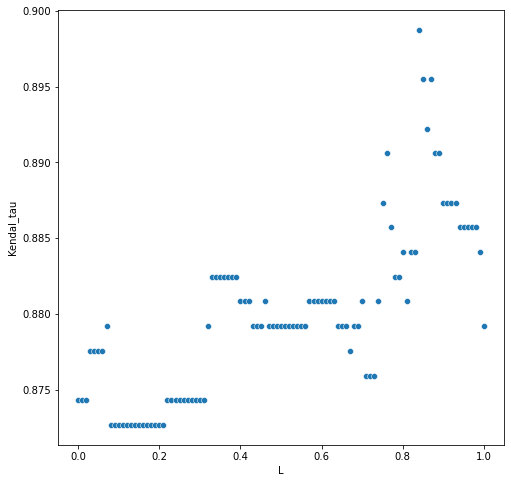

In [44]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(x=(df_res['L']), y=(df_res['Kendal_tau']), palette="tab10")



# Utility vs Kendall-tau

<AxesSubplot:xlabel='Utility_mean', ylabel='Kendal_tau'>

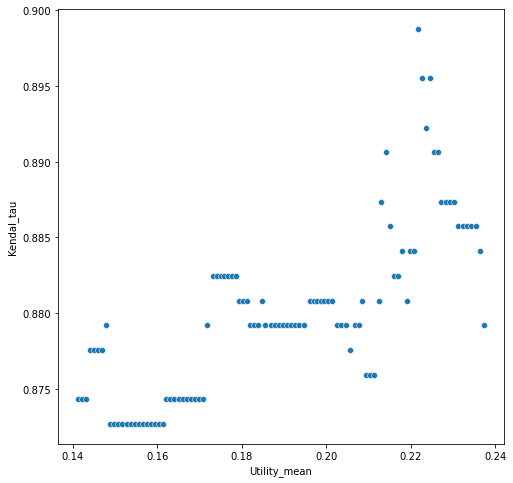

In [45]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(x=(df_res['Utility_mean']), y=(df_res['Kendal_tau']), palette="tab10")



# alpha aggiustato vs kendall-tau

Text(0, 0.5, 'Kendall_tau')

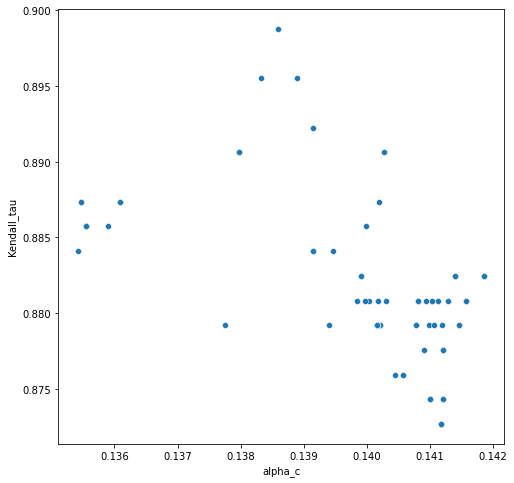

In [46]:
f = plt.figure(figsize=(8,8))
sns.scatterplot(x=(df_res['alpha_adj']), y=(df_res['Kendal_tau']), palette="tab10")

plt.xlabel("alpha_c")
plt.ylabel("Kendall_tau")

# Analisi di sensitività congiunta per alpha e L

In [47]:
alpha_list = numpy.arange(0.01, 0.21, 0.01)
L_list = numpy.arange(0, 1.01, 0.01)
import Greedy_Wise_Utility
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


intervals_utility = []
intervals_alpha = []

attributeQuality = 'Score'
res = []
confidence = 0.90

for alpha in alpha_list:
    for L in L_list:

        json_data = open('.\german_credit.json').read()
        data = numpy.array(json_data.split("\n"))
        data_set = []
        ## Clean the data
        for i in data:
            data_set.append(ast.literal_eval(i))    
        attribute = {'Group':4}  


        #initialization
#         alpha = 0.1
        p = [0.4,0.3,0.2,0.1]
        k_th = 51
        ## Definiamo un parametro di loss L per bilanciare tra fairness e utilità

        attributes = {'Group':4}
        #Sort Values
        data_sert = sorted(data_set, reverse=True,key = lambda user: (user['Score']))
        data_set = data_sert

        for diz, i in zip(data_set, range(len(data_set))):
            diz['k'] = i + 1 


        cb_rank = pd.DataFrame(data_set)
        cb_rank['DCG_PreR'] = cb_rank['Score']/(numpy.log(2 + cb_rank['k']))
        new_rank, exposureByGroups, countByGroups, exposureStd, alphaByGroups, DCGByGroups = Greedy_Wise_Utility.GWU(data_set, p, alpha, k_th, attributeQuality, attributes, 'Group', L)
        new_rank['alpha_thresh'] = alpha
        new_rank['PreR_DCG'] = new_rank['Score']/(numpy.log(2 + new_rank['k']))
        new_rank['PostR_DCG'] = new_rank['Score']/(numpy.log(2 + new_rank['new_k']))
        new_rank['Utility_Loss_individual'] = new_rank['PostR_DCG']-new_rank['PreR_DCG']
        new_rank['Utility_Loss_position'] = new_rank['PostR_DCG']-cb_rank['DCG_PreR']
        new_rank['ULP*ULI'] = new_rank['Utility_Loss_position']*new_rank['Utility_Loss_individual']

        # calculate the kendall's correlation between two variables
        # calculate kendall's correlation    
        coef, p = kendalltau(new_rank['PostR_DCG'], cb_rank['DCG_PreR'].head(50))
    #     print('Kendall correlation coefficient: %.3f' % coef)
        # interpret the significance
    #     alpha = 0.1
    #     if p > alpha:
    #         print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    #     else:
    #         print('Samples are correlated (reject H0) p=%.3f' % p)

        diz_results = {}
        diz_exposure = {}
        diz_DCG = {}
        diz_alpha = {}
        diz_results['L'] = L
        diz_results['DCG'] =  new_rank['PostR_DCG'].mean()
        diz_results['Utility'] = new_rank['Utility_adj'].sum()
        diz_results['Utility_mean'] = new_rank['Utility_adj'].mean()
        diz_results['Utility_std'] = new_rank['Utility_adj'].std()
        diz_results['alpha'] = alpha
        diz_results['kendal_tau'] = coef
        diz_results['alpha_adj'] = new_rank['alpha_adj'].mean()
        diz_results['alphaAdjStd'] = new_rank['alpha_adj'].std()
        dof = len(new_rank)-1 


        t_crit = numpy.abs(t.ppf((1-confidence)/2,dof))
        
        diz_alpha['alphaByGroups'] = alphaByGroups
        diz_DCG['DCGByGroups'] = DCGByGroups
        diz_exposure['exposureByGroups'] = exposureByGroups
        diz_exposure['L'] = L
        diz_exposure['alpha'] = alpha
        diz_exposure['countByGroups'] = countByGroups
        diz_exposure['exposureStd'] = exposureStd
        diz_results['alphaByGroups'] = diz_alpha
        diz_results['ExposureByGroups'] = diz_exposure
        diz_results['DCGByGroups'] = diz_DCG

        interval_utility =(diz_results['Utility_mean']-diz_results['Utility_std']*t_crit/numpy.sqrt(dof+1)
                          ,diz_results['Utility_mean']+diz_results['Utility_std']*t_crit/numpy.sqrt(dof+1)) 



        interval_alpha = (diz_results['alpha_adj']-diz_results['alphaAdjStd']*t_crit/numpy.sqrt(dof+1)
                         ,diz_results['alpha_adj']+diz_results['alphaAdjStd']*t_crit/numpy.sqrt(dof+1)) 



    #     new_rank.groupby
        diz_results['lower_alpha_int'] = interval_alpha[0]
        diz_results['upper_alpha_int'] = interval_alpha[1]

        intervals_alpha.append(interval_alpha)
        intervals_utility.append(interval_utility)
        diz_results['Kendal_tau'] = coef 


        res.append(diz_results)

df_res = pd.DataFrame(res)

Function 'GWU' executed in 0.6599s
Function 'GWU' executed in 0.6886s
Function 'GWU' executed in 0.6222s
Function 'GWU' executed in 0.5721s
Function 'GWU' executed in 0.6106s
Function 'GWU' executed in 0.5572s
Function 'GWU' executed in 0.6185s
Function 'GWU' executed in 0.5570s
Function 'GWU' executed in 0.5329s
Function 'GWU' executed in 0.5585s
Function 'GWU' executed in 0.6360s
Function 'GWU' executed in 0.6258s
Function 'GWU' executed in 0.5149s
Function 'GWU' executed in 0.5557s
Function 'GWU' executed in 0.5882s
Function 'GWU' executed in 0.6036s
Function 'GWU' executed in 0.5719s
Function 'GWU' executed in 0.5180s
Function 'GWU' executed in 0.5636s
Function 'GWU' executed in 0.6085s
Function 'GWU' executed in 0.5608s
Function 'GWU' executed in 0.5669s
Function 'GWU' executed in 0.6428s
Function 'GWU' executed in 0.7594s
Function 'GWU' executed in 0.6670s
Function 'GWU' executed in 0.8082s
Function 'GWU' executed in 0.7630s
Function 'GWU' executed in 0.7374s
Function 'GWU' execu

Function 'GWU' executed in 0.5727s
Function 'GWU' executed in 0.5521s
Function 'GWU' executed in 0.5384s
Function 'GWU' executed in 0.6022s
Function 'GWU' executed in 0.6393s
Function 'GWU' executed in 0.5792s
Function 'GWU' executed in 0.5657s
Function 'GWU' executed in 0.5754s
Function 'GWU' executed in 0.5308s
Function 'GWU' executed in 0.5563s
Function 'GWU' executed in 0.5717s
Function 'GWU' executed in 0.6129s
Function 'GWU' executed in 0.5776s
Function 'GWU' executed in 0.6553s
Function 'GWU' executed in 0.6581s
Function 'GWU' executed in 0.6746s
Function 'GWU' executed in 0.6648s
Function 'GWU' executed in 0.6224s
Function 'GWU' executed in 0.6058s
Function 'GWU' executed in 0.5753s
Function 'GWU' executed in 0.5932s
Function 'GWU' executed in 0.5401s
Function 'GWU' executed in 0.5802s
Function 'GWU' executed in 0.5899s
Function 'GWU' executed in 0.5592s
Function 'GWU' executed in 0.6122s
Function 'GWU' executed in 0.5652s
Function 'GWU' executed in 0.5976s
Function 'GWU' execu

Function 'GWU' executed in 0.5735s
Function 'GWU' executed in 0.6034s
Function 'GWU' executed in 0.5890s
Function 'GWU' executed in 0.5755s
Function 'GWU' executed in 0.5892s
Function 'GWU' executed in 0.5699s
Function 'GWU' executed in 0.5915s
Function 'GWU' executed in 0.5688s
Function 'GWU' executed in 0.5810s
Function 'GWU' executed in 0.5840s
Function 'GWU' executed in 0.5808s
Function 'GWU' executed in 0.5759s
Function 'GWU' executed in 0.5617s
Function 'GWU' executed in 0.5737s
Function 'GWU' executed in 0.5826s
Function 'GWU' executed in 0.5647s
Function 'GWU' executed in 0.6237s
Function 'GWU' executed in 0.5649s
Function 'GWU' executed in 0.6121s
Function 'GWU' executed in 0.5680s
Function 'GWU' executed in 0.5578s
Function 'GWU' executed in 0.6522s
Function 'GWU' executed in 0.6877s
Function 'GWU' executed in 0.6738s
Function 'GWU' executed in 0.5967s
Function 'GWU' executed in 0.6060s
Function 'GWU' executed in 0.5704s
Function 'GWU' executed in 0.5752s
Function 'GWU' execu

Function 'GWU' executed in 0.5918s
Function 'GWU' executed in 0.5512s
Function 'GWU' executed in 0.5841s
Function 'GWU' executed in 0.6471s
Function 'GWU' executed in 0.5961s
Function 'GWU' executed in 0.5951s
Function 'GWU' executed in 0.6212s
Function 'GWU' executed in 0.6177s
Function 'GWU' executed in 0.5738s
Function 'GWU' executed in 0.6202s
Function 'GWU' executed in 0.6230s
Function 'GWU' executed in 0.6208s
Function 'GWU' executed in 0.6003s
Function 'GWU' executed in 0.5465s
Function 'GWU' executed in 0.5542s
Function 'GWU' executed in 0.5624s
Function 'GWU' executed in 0.5658s
Function 'GWU' executed in 0.6370s
Function 'GWU' executed in 0.6813s
Function 'GWU' executed in 0.7096s
Function 'GWU' executed in 0.6578s
Function 'GWU' executed in 0.6318s
Function 'GWU' executed in 0.5793s
Function 'GWU' executed in 0.5808s
Function 'GWU' executed in 0.5691s
Function 'GWU' executed in 0.5818s
Function 'GWU' executed in 0.5630s
Function 'GWU' executed in 0.5941s
Function 'GWU' execu

Function 'GWU' executed in 0.5882s
Function 'GWU' executed in 0.6876s
Function 'GWU' executed in 0.6346s
Function 'GWU' executed in 0.7083s
Function 'GWU' executed in 0.6668s
Function 'GWU' executed in 0.6783s
Function 'GWU' executed in 0.6451s
Function 'GWU' executed in 0.5804s
Function 'GWU' executed in 0.6055s
Function 'GWU' executed in 0.6530s
Function 'GWU' executed in 0.6211s
Function 'GWU' executed in 0.5873s
Function 'GWU' executed in 0.5941s
Function 'GWU' executed in 0.5670s
Function 'GWU' executed in 0.5656s
Function 'GWU' executed in 0.5791s
Function 'GWU' executed in 0.5771s
Function 'GWU' executed in 0.6002s
Function 'GWU' executed in 0.6568s
Function 'GWU' executed in 0.5616s
Function 'GWU' executed in 0.6249s
Function 'GWU' executed in 0.5759s
Function 'GWU' executed in 0.5543s
Function 'GWU' executed in 0.6066s
Function 'GWU' executed in 0.5618s
Function 'GWU' executed in 0.5617s
Function 'GWU' executed in 0.6205s
Function 'GWU' executed in 0.6493s
Function 'GWU' execu

Function 'GWU' executed in 0.6003s
Function 'GWU' executed in 0.6318s
Function 'GWU' executed in 0.6543s
Function 'GWU' executed in 0.7142s
Function 'GWU' executed in 0.7310s
Function 'GWU' executed in 0.6342s
Function 'GWU' executed in 0.6917s
Function 'GWU' executed in 0.6182s
Function 'GWU' executed in 0.5814s
Function 'GWU' executed in 0.6151s
Function 'GWU' executed in 0.5863s
Function 'GWU' executed in 0.5895s
Function 'GWU' executed in 0.5856s
Function 'GWU' executed in 0.6080s
Function 'GWU' executed in 0.5731s
Function 'GWU' executed in 0.5862s
Function 'GWU' executed in 0.7207s
Function 'GWU' executed in 0.6303s
Function 'GWU' executed in 0.6329s
Function 'GWU' executed in 0.6191s
Function 'GWU' executed in 0.6016s
Function 'GWU' executed in 0.5984s
Function 'GWU' executed in 0.5919s
Function 'GWU' executed in 0.5805s
Function 'GWU' executed in 0.6009s
Function 'GWU' executed in 0.5644s
Function 'GWU' executed in 0.6325s
Function 'GWU' executed in 0.6122s
Function 'GWU' execu

Function 'GWU' executed in 0.5387s
Function 'GWU' executed in 0.5687s
Function 'GWU' executed in 0.6130s
Function 'GWU' executed in 0.6244s
Function 'GWU' executed in 0.5956s
Function 'GWU' executed in 0.5885s
Function 'GWU' executed in 0.6322s
Function 'GWU' executed in 0.6544s
Function 'GWU' executed in 0.6858s
Function 'GWU' executed in 0.6705s
Function 'GWU' executed in 0.6485s
Function 'GWU' executed in 0.6635s
Function 'GWU' executed in 0.5883s
Function 'GWU' executed in 0.5711s
Function 'GWU' executed in 0.6583s
Function 'GWU' executed in 0.6013s
Function 'GWU' executed in 0.6084s
Function 'GWU' executed in 0.5465s
Function 'GWU' executed in 0.5461s
Function 'GWU' executed in 0.5484s
Function 'GWU' executed in 0.5836s
Function 'GWU' executed in 0.5717s
Function 'GWU' executed in 0.5944s
Function 'GWU' executed in 0.6700s
Function 'GWU' executed in 0.6310s
Function 'GWU' executed in 0.6638s
Function 'GWU' executed in 0.6290s
Function 'GWU' executed in 0.5776s
Function 'GWU' execu

Function 'GWU' executed in 0.6274s
Function 'GWU' executed in 0.5849s
Function 'GWU' executed in 0.5652s
Function 'GWU' executed in 0.5786s
Function 'GWU' executed in 0.5698s
Function 'GWU' executed in 0.5589s
Function 'GWU' executed in 0.6063s
Function 'GWU' executed in 0.5724s
Function 'GWU' executed in 0.6053s
Function 'GWU' executed in 0.6050s
Function 'GWU' executed in 0.6381s
Function 'GWU' executed in 0.7029s
Function 'GWU' executed in 0.7275s
Function 'GWU' executed in 0.6387s
Function 'GWU' executed in 0.6153s
Function 'GWU' executed in 0.6019s
Function 'GWU' executed in 0.5662s
Function 'GWU' executed in 0.5882s
Function 'GWU' executed in 0.5921s
Function 'GWU' executed in 0.6394s
Function 'GWU' executed in 0.6032s
Function 'GWU' executed in 0.5429s
Function 'GWU' executed in 0.6148s
Function 'GWU' executed in 0.5761s
Function 'GWU' executed in 0.5669s
Function 'GWU' executed in 0.5752s
Function 'GWU' executed in 0.6116s
Function 'GWU' executed in 0.5897s
Function 'GWU' execu

Function 'GWU' executed in 0.5981s
Function 'GWU' executed in 0.6552s
Function 'GWU' executed in 0.6186s
Function 'GWU' executed in 0.6131s
Function 'GWU' executed in 0.6607s
Function 'GWU' executed in 0.6158s
Function 'GWU' executed in 0.5462s
Function 'GWU' executed in 0.5893s
Function 'GWU' executed in 0.5735s
Function 'GWU' executed in 0.5675s
Function 'GWU' executed in 0.6034s
Function 'GWU' executed in 0.6265s
Function 'GWU' executed in 0.5902s
Function 'GWU' executed in 0.6067s
Function 'GWU' executed in 0.5960s
Function 'GWU' executed in 0.5833s
Function 'GWU' executed in 0.6670s
Function 'GWU' executed in 0.6434s
Function 'GWU' executed in 0.6962s
Function 'GWU' executed in 0.6484s
Function 'GWU' executed in 0.5768s
Function 'GWU' executed in 0.6110s
Function 'GWU' executed in 0.6696s
Function 'GWU' executed in 0.6058s
Function 'GWU' executed in 0.5958s
Function 'GWU' executed in 0.6493s
Function 'GWU' executed in 0.5772s
Function 'GWU' executed in 0.5743s
Function 'GWU' execu

In [48]:
df_res['ExposureByGroups'][0]['exposureByGroups'][0]

0.3698358289250849

In [49]:
df_res['DTR_1'] = df_res['ExposureByGroups'].apply(lambda x: x['exposureByGroups'][0]/x['exposureByGroups'][1] - 1)

In [50]:
df_res['DTR_2'] = df_res['ExposureByGroups'].apply(lambda x: x['exposureByGroups'][0]/x['exposureByGroups'][2] - 1)

In [51]:
df_res['DTR_3'] = df_res['ExposureByGroups'].apply(lambda x: x['exposureByGroups'][0]/x['exposureByGroups'][3] - 1)

In [52]:
df_res['Metric'] = df_res['kendal_tau']*df_res['alpha_adj'] - (df_res['DTR_1']*0.3 + df_res['DTR_2']*0.2 + df_res['DTR_3']*0.1)

In [53]:
df_res.loc[df_res['Metric'].idxmax()]

L                                                                 0.6
DCG                                                          0.236093
Utility                                                     12.253282
Utility_mean                                                 0.245066
Utility_std                                                  0.080428
alpha                                                             0.2
kendal_tau                                                    0.86449
alpha_adj                                                    0.258524
alphaAdjStd                                                  0.055772
alphaByGroups       {'alphaByGroups': [0.23727657096863705, 0.2619...
ExposureByGroups    {'exposureByGroups': [0.3619259164075933, 0.34...
DCGByGroups         {'DCGByGroups': [0.2598267825988372, 0.2371322...
lower_alpha_int                                              0.245301
upper_alpha_int                                              0.271748
Kendal_tau          

In [56]:
exposureData = []
intervalsExposure = []
for row, row1, row2 in zip(df_res['ExposureByGroups'], df_res['alphaByGroups'], df_res['DCGByGroups']):
    count = 0
    for meanExp, countExp, exposureStd, meanAlpha, meanDCG in zip(row['exposureByGroups'], row['countByGroups'], row['exposureStd'], row1['alphaByGroups'], row2['DCGByGroups']):
        diz = {}
        diz['Group'] = count
        diz['averageExposure'] = meanExp
        diz['alpha_c'] = meanAlpha
        diz['meanDCG'] = meanDCG
        diz['lenGroup'] = countExp -1
        diz['exposureStd'] = exposureStd
        t_crit = numpy.abs(t.ppf((1-confidence)/2,dof))
        
        interval_utility =(diz['averageExposure']-diz['exposureStd']*t_crit/numpy.sqrt(diz['lenGroup'])
        ,diz['averageExposure']+diz['exposureStd']*t_crit/numpy.sqrt(diz['lenGroup'])) 
        
        diz['upper_int']=interval_utility[1]
        diz['lower_int'] = interval_utility[0]
        
#         intervalsExposure.append(interval_utility)
        diz['L'] = row['L']
        diz['alpha'] = row['alpha']
        count = count + 1
        exposureData.append(diz)
        
exposureDf = pd.DataFrame(exposureData)


In [57]:
# exposureDf.to_csv('exposureDf.csv')
exposureDf.to_excel('exposureDf.xlsx')

# Exposure at L and alpha variation

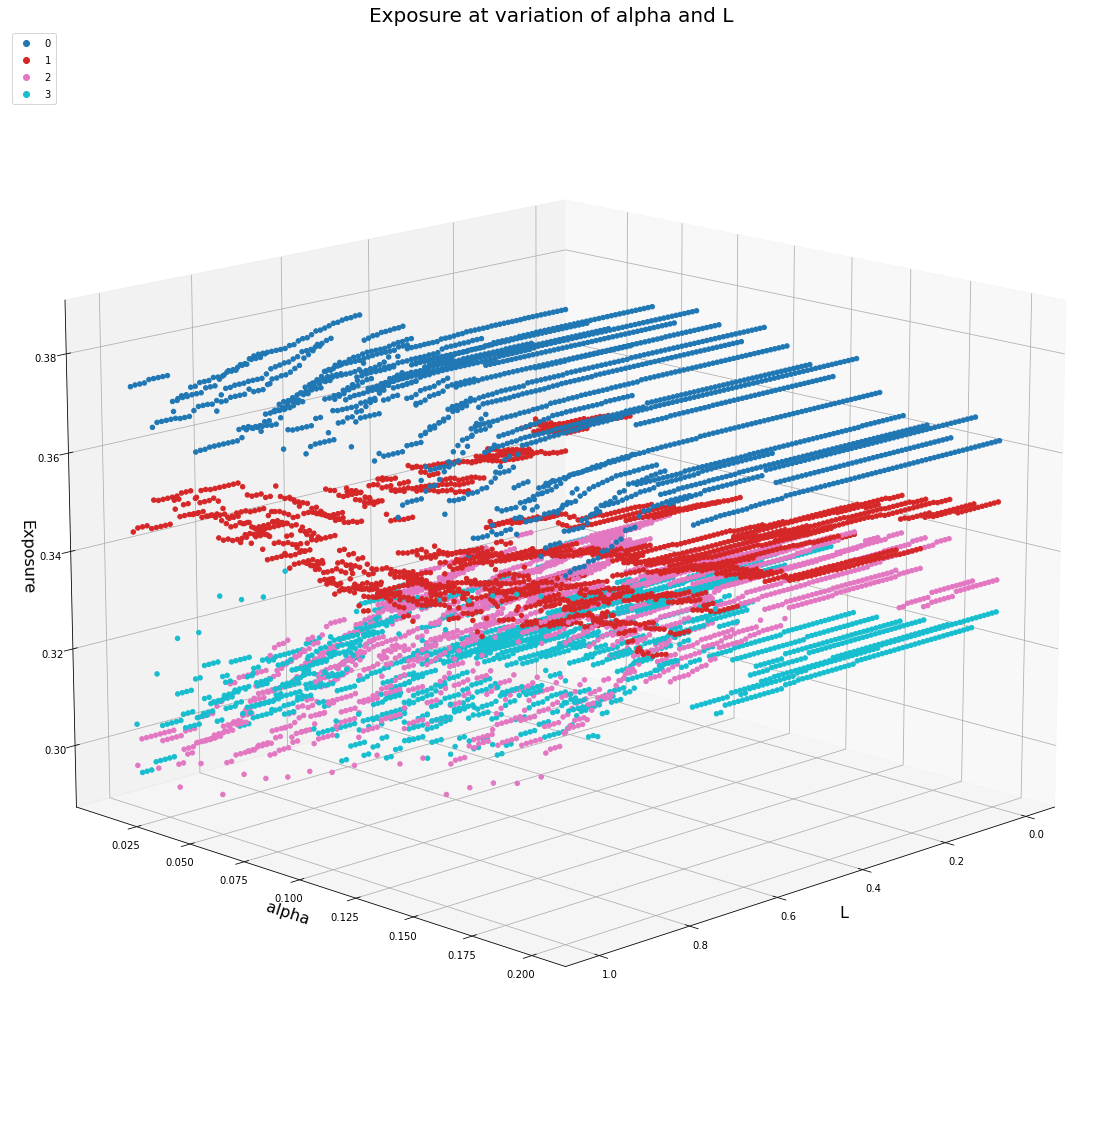

In [59]:
import Greedy_Wise_Utility
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.set_title("Exposure at variation of alpha and L", 
             fontsize=20)
ax.set_xlabel("L",
              fontsize=16)
ax.set_ylabel("alpha", 
              fontsize=16)
ax.set_zlabel("Exposure", 
              fontsize=16)


cmap = ListedColormap(sns.color_palette("tab10").as_hex())
sc = ax.scatter( exposureDf['L'], exposureDf['alpha'],exposureDf['averageExposure'], c=exposureDf['Group'], cmap = cmap, alpha=1)
# handles, labels = ax.get_legend_handles_labels()

plt.legend(*sc.legend_elements(), bbox_to_anchor = (0, 1), loc=2)


ax.text(2.1,9.4,5.0,
       "1",fontsize= 10)

ax.view_init(elev=15., azim=45)

# er i gruppi protetti inserire un colore in 'crescendo da chiaro a scuro'

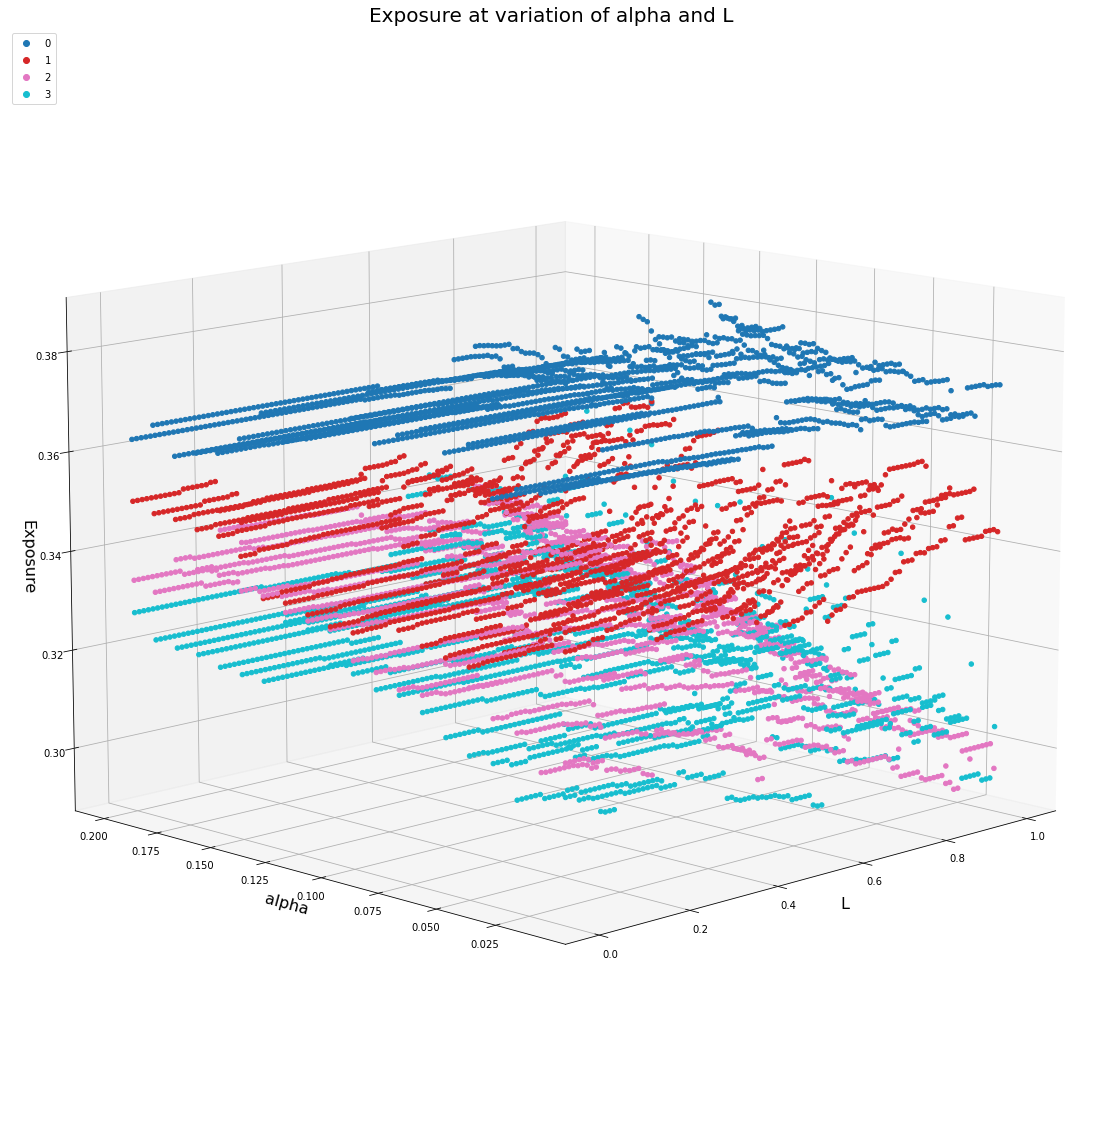

In [60]:
import Greedy_Wise_Utility
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.set_title("Exposure at variation of alpha and L", 
             fontsize=20)
ax.set_xlabel("L",
              fontsize=16)
ax.set_ylabel("alpha", 
              fontsize=16)
ax.set_zlabel("Exposure", 
              fontsize=16)


cmap = ListedColormap(sns.color_palette("tab10").as_hex())
sc = ax.scatter( exposureDf['L'], exposureDf['alpha'],exposureDf['averageExposure'], c=exposureDf['Group'], cmap = cmap, alpha=1)
# handles, labels = ax.get_legend_handles_labels()

plt.legend(*sc.legend_elements(), bbox_to_anchor = (0, 1), loc=2)


ax.text(2.1,9.4,5.0,
       "1",fontsize= 10)

ax.view_init(elev=12., azim=-135)

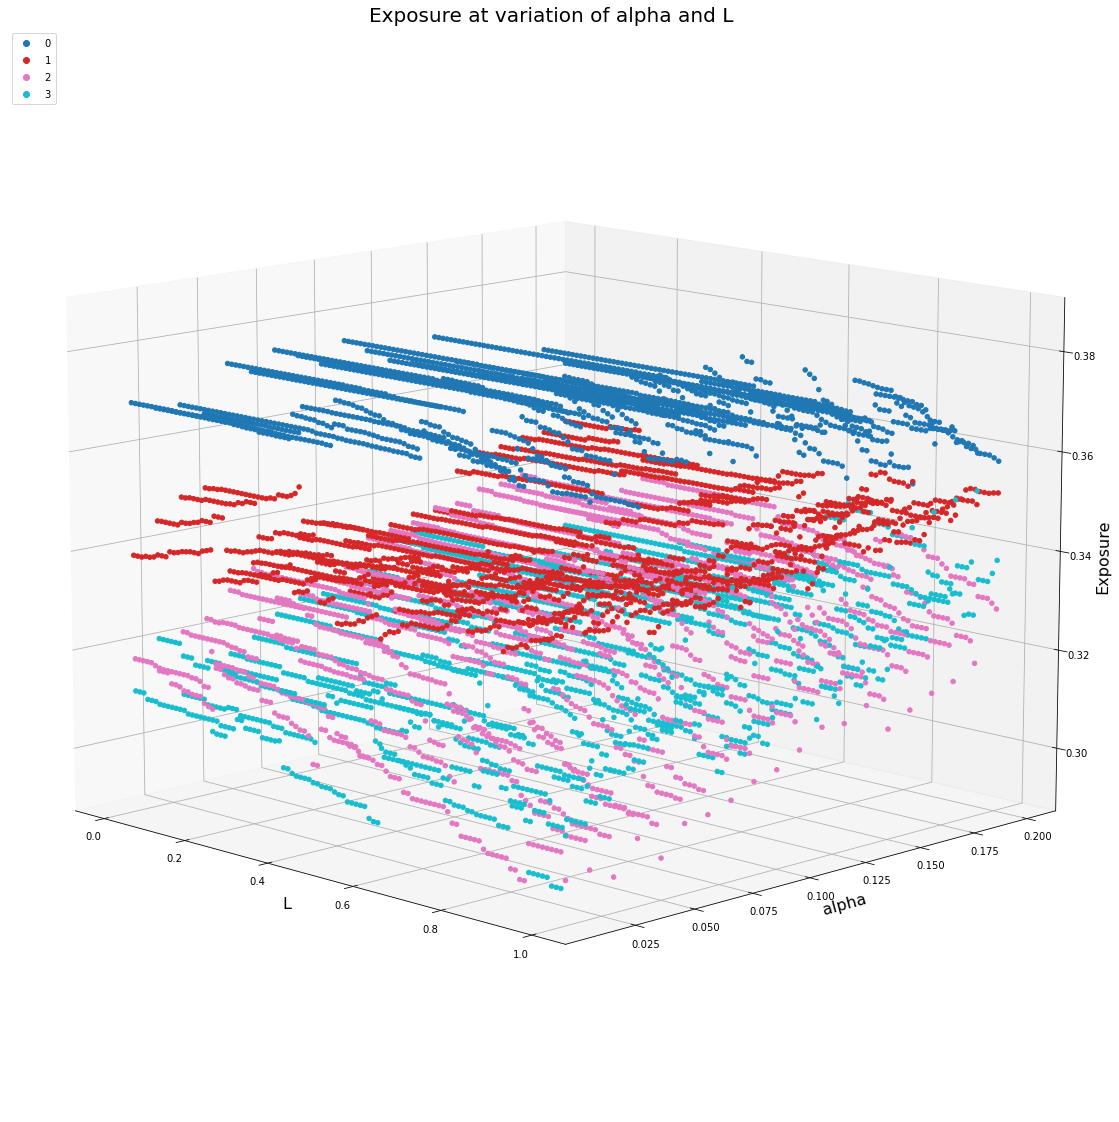

In [61]:
import Greedy_Wise_Utility
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.set_title("Exposure at variation of alpha and L", 
             fontsize=20)
ax.set_xlabel("L",
              fontsize=16)
ax.set_ylabel("alpha", 
              fontsize=16)
ax.set_zlabel("Exposure", 
              fontsize=16)


cmap = ListedColormap(sns.color_palette("tab10").as_hex())
sc = ax.scatter( exposureDf['L'], exposureDf['alpha'],exposureDf['averageExposure'], c=exposureDf['Group'], cmap = cmap, alpha=1)
# handles, labels = ax.get_legend_handles_labels()

plt.legend(*sc.legend_elements(), bbox_to_anchor = (0, 1), loc=2)


ax.text(2.1,9.4,5.0,
       "1",fontsize= 10)

ax.view_init(elev=12., azim=-45)

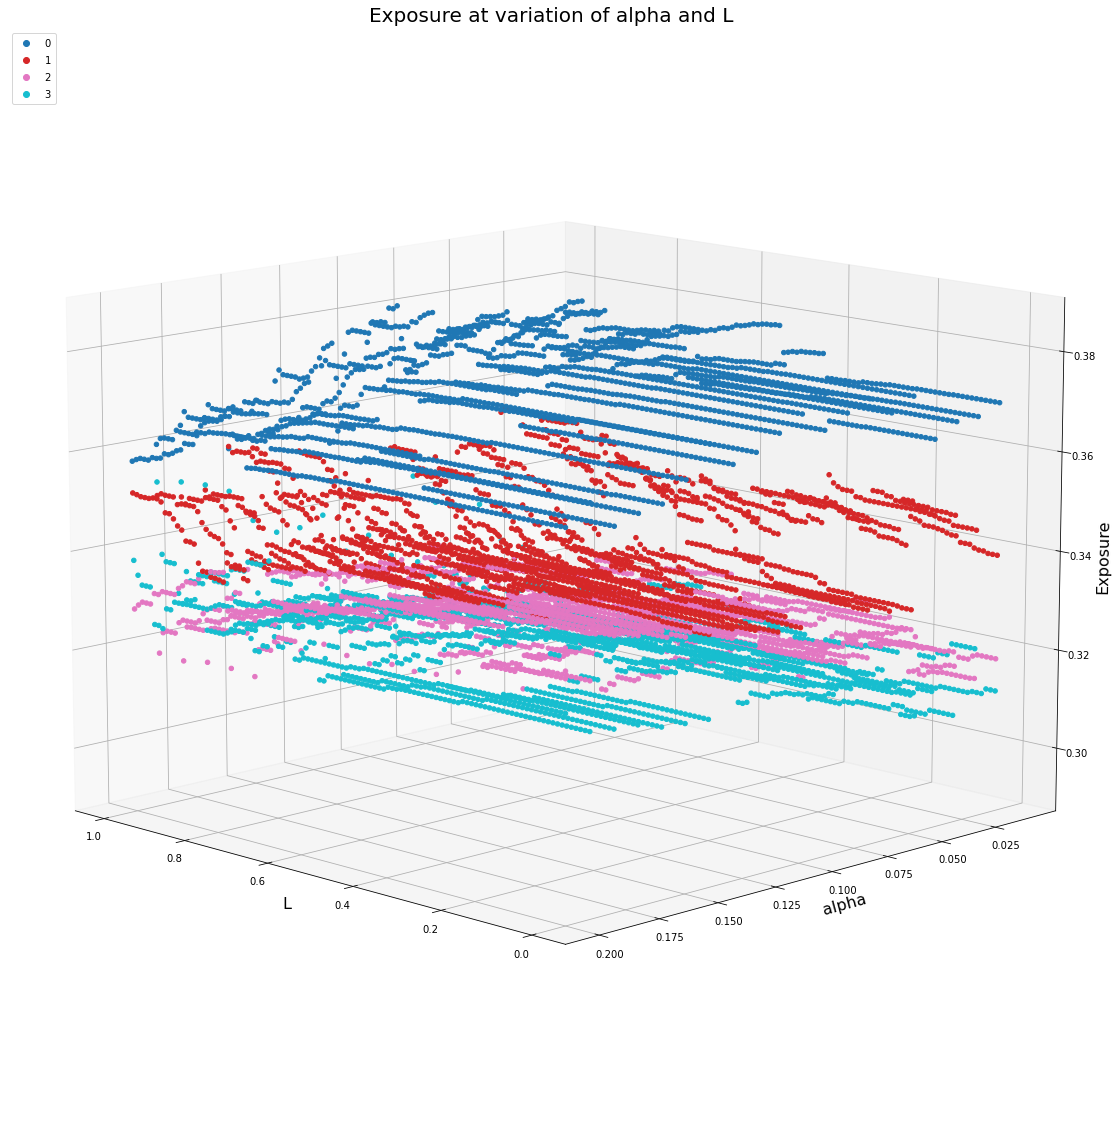

In [62]:

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.set_title("Exposure at variation of alpha and L", 
             fontsize=20)
ax.set_xlabel("L",
              fontsize=16)
ax.set_ylabel("alpha", 
              fontsize=16)
ax.set_zlabel("Exposure", 
              fontsize=16)


cmap = ListedColormap(sns.color_palette("tab10").as_hex())
sc = ax.scatter( exposureDf['L'], exposureDf['alpha'],exposureDf['averageExposure'], c=exposureDf['Group'], cmap = cmap, alpha=1)
# handles, labels = ax.get_legend_handles_labels()

plt.legend(*sc.legend_elements(), bbox_to_anchor = (0, 1), loc=2)


ax.text(2.1,9.4,5.0,
       "1",fontsize= 10)

ax.view_init(elev=12., azim=135)

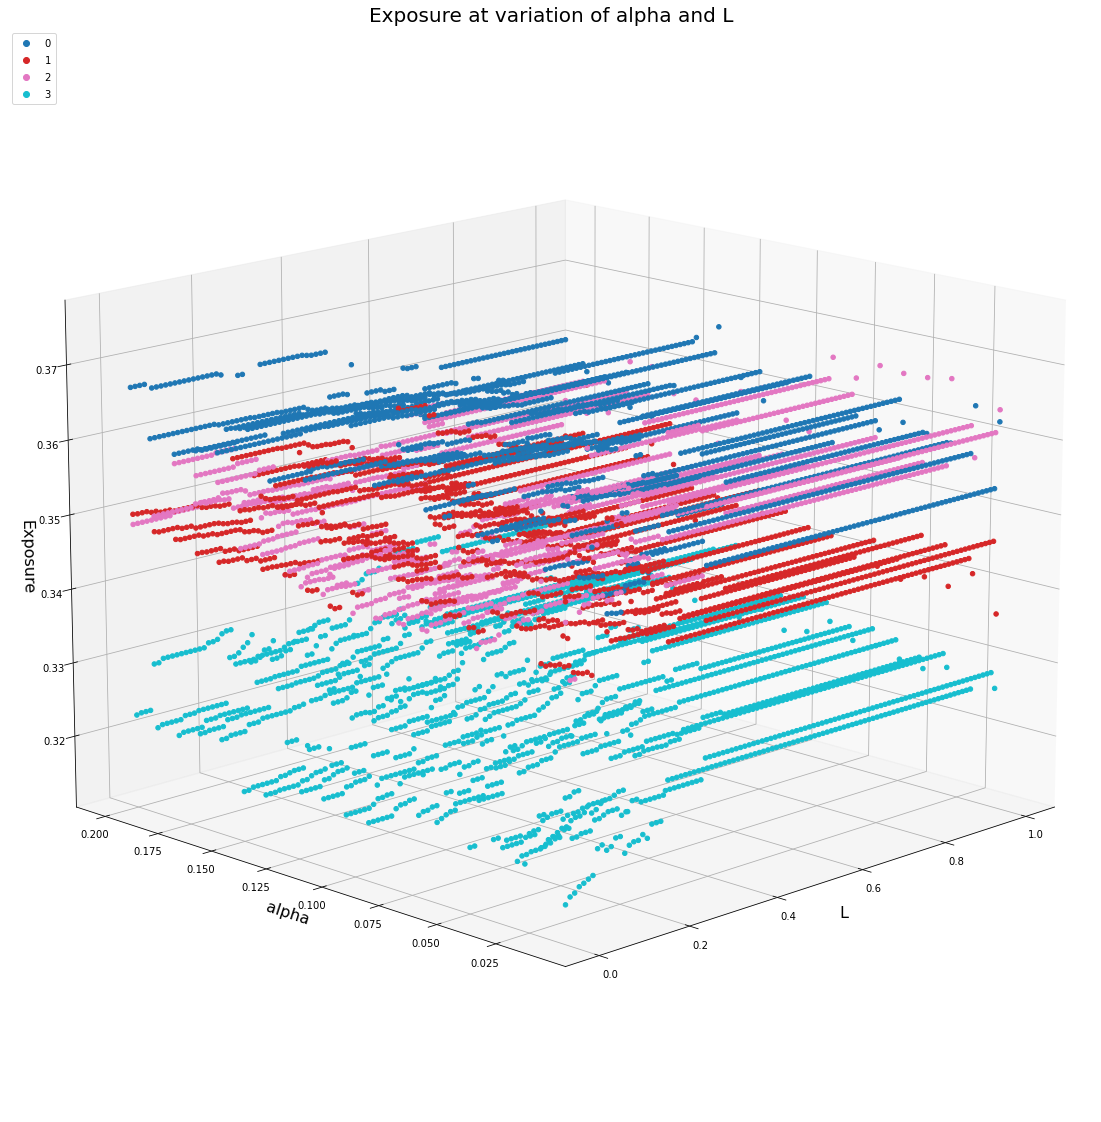

In [356]:
import Greedy_Wise_Utility
from numpy.random import rand
from numpy.random import seed
from scipy.stats import kendalltau
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

ax.set_title("Exposure at variation of alpha and L", 
             fontsize=20)
ax.set_xlabel("L",
              fontsize=16)
ax.set_ylabel("alpha", 
              fontsize=16)
ax.set_zlabel("Exposure", 
              fontsize=16)


cmap = ListedColormap(sns.color_palette("tab10").as_hex())
sc = ax.scatter( exposureDf['L'], exposureDf['alpha'],exposureDf['averageExposure'], c=exposureDf['Group'], cmap = cmap, alpha=1)
# handles, labels = ax.get_legend_handles_labels()

plt.legend(*sc.legend_elements(), bbox_to_anchor = (0, 1), loc=2)


ax.text(2.1,9.4,5.0,
       "1",fontsize= 10)

ax.view_init(elev=15., azim=-135)

# er i gruppi protetti inserire un colore in 'crescendo da chiaro a scuro'